# **TDS - Credit Risk Dataset**

Roni Hemed, Roy Maman

## Analyze the data

### Imports

In [2]:
# Data processing
import pandas as pd
import numpy as np

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import shap
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint

import json
import warnings
warnings.filterwarnings("ignore")


### Loading the CSV dataset

Load dataset

In [3]:
dtf = pd.read_csv("./credit_risk_dataset.csv")
dtf.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
dtf.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### Examining the target feature - "loan_status": Using a histogram and a KDE plot

 The predictive problem is developing a model to predict whether a client will default on a loan. Then now we'll be examining the target feature - "loan-status" which his value is 0 for No Default, and 1 for Default.

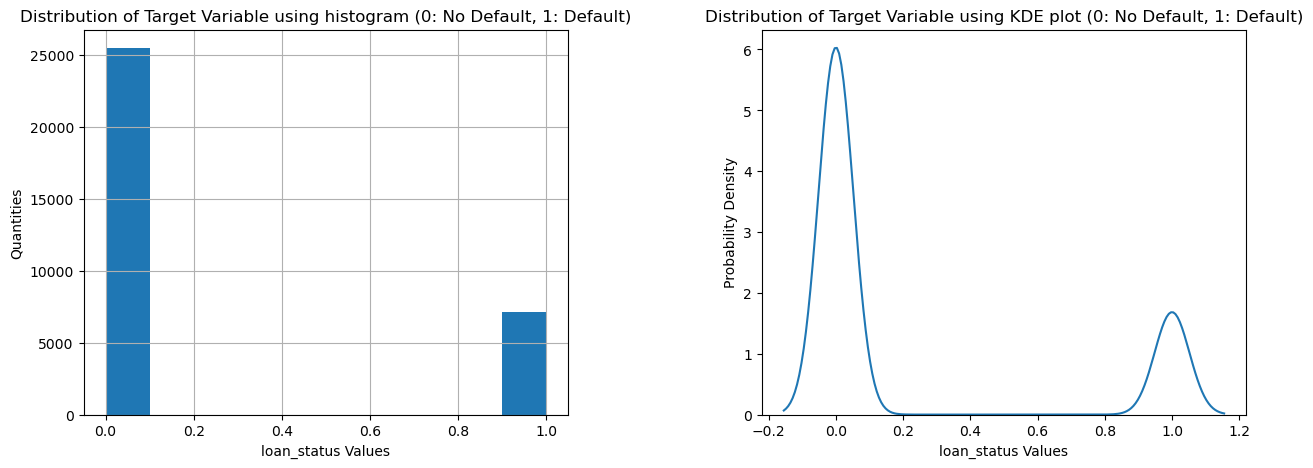

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(wspace=0.4, hspace=1)

dtf.loan_status.hist(ax=axes[0])
axes[0].set_title('Distribution of Target Variable using histogram (0: No Default, 1: Default)')
axes[0].set_xlabel('loan_status Values')
axes[0].set_ylabel('Quantities')

sns.kdeplot(dtf.loan_status, ax=axes[1])
axes[1].set_title('Distribution of Target Variable using KDE plot (0: No Default, 1: Default)')
axes[1].set_xlabel('loan_status Values')
axes[1].set_ylabel('Probability Density')

plt.show()

We can see from the distributions that the data is imbalanced - there are a lot more clients which are not default on a loan, comparing to clients which are default on a loan.

### Examining Correlations to the target feature:

<Axes: >

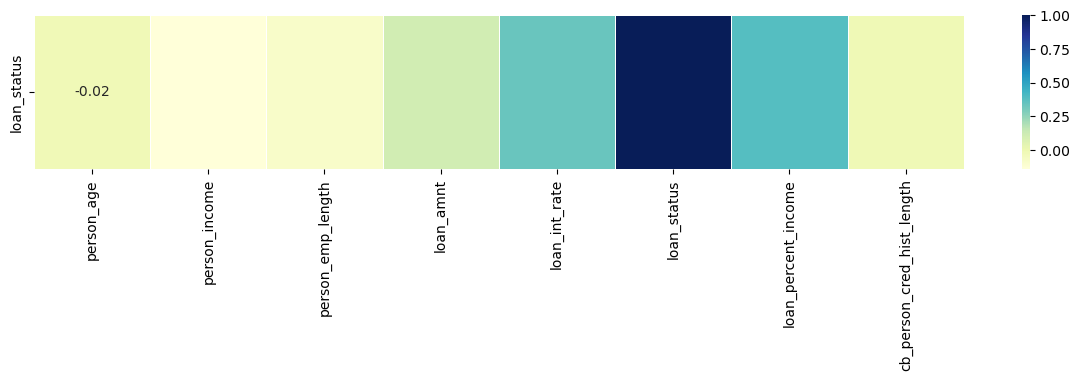

In [7]:
numeric_dtf = dtf.select_dtypes(include='number')
dtf_corr = numeric_dtf.corr(method="pearson").loc[["loan_status"]]
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

We observe a higher correlation between "loan_status" (the target feature) and "loan_int_rate" as well as "loan_percent_income". Subsequently, we can investigate how these features influence the "loan_status."

### Visualzing relevant feature-pair relations:

Let's analyze the relations between "loan_int_rate" and "loan_status"

<Axes: xlabel='loan_int_rate', ylabel='loan_status'>

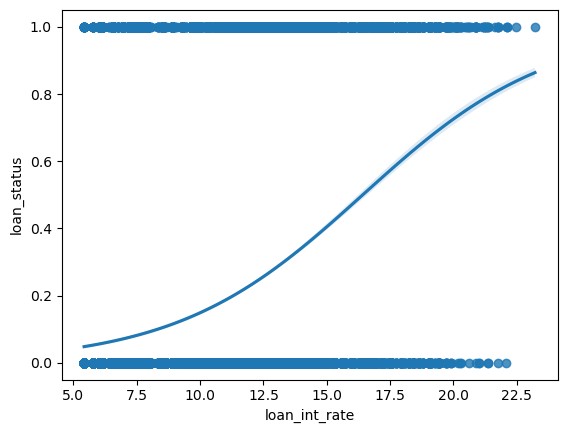

In [8]:
sns.regplot(data=dtf, x='loan_int_rate', y='loan_status', logistic=True)

We can see that as long as "loan_int_rate" is rising, "loan_status" closer to 1.

<Axes: xlabel='loan_percent_income', ylabel='loan_status'>

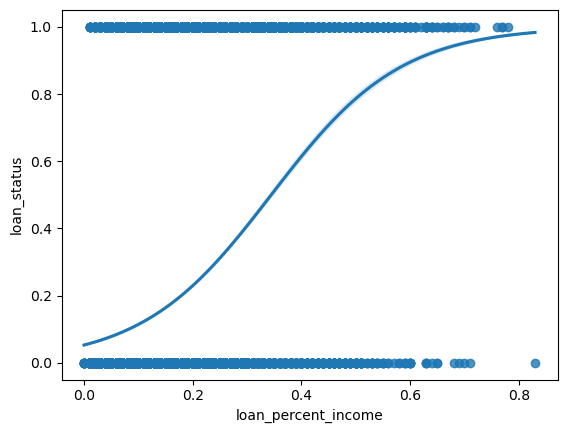

In [9]:
sns.regplot(data=dtf, x='loan_percent_income',y='loan_status', logistic=True)

We can see also that as long as "loan_percent_income" is rising, "loan_status" closer to 1.

These graphs are not informative enough, so let's look at the correlation between 'loan_percent_income', 'loan_int_rate', when the 'loan_status' is 0 the dot is blue and when it's 1 the dot is red.

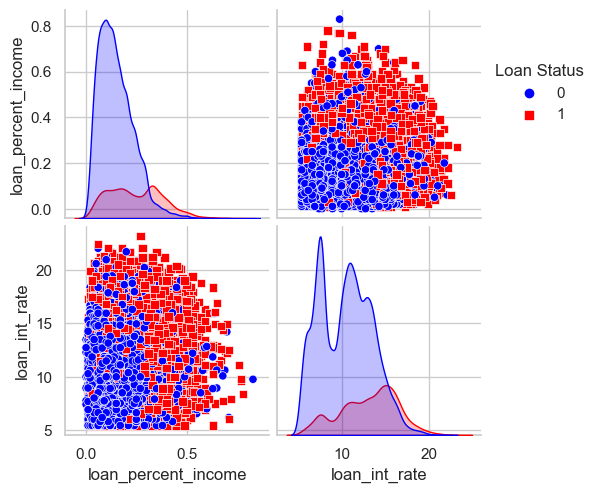

In [10]:
sns.set(style="whitegrid")
pair_plot = sns.pairplot(dtf, hue='loan_status', palette={0: 'blue', 1: 'red'},
                        vars=['loan_percent_income', 'loan_int_rate'], markers=["o", "s"])
pair_plot._legend.set_title('Loan Status')
pair_plot._legend.set_bbox_to_anchor([1, 0.8])

plt.show()


From this we can also see that when "loan_percent_income" or "loan_int_rate" is rising, "loan_status" equal to 1 quantity is bigger.

Let's analyze also the relations between "loan_status" and whether a client own a house or not ("person_home_ownership")

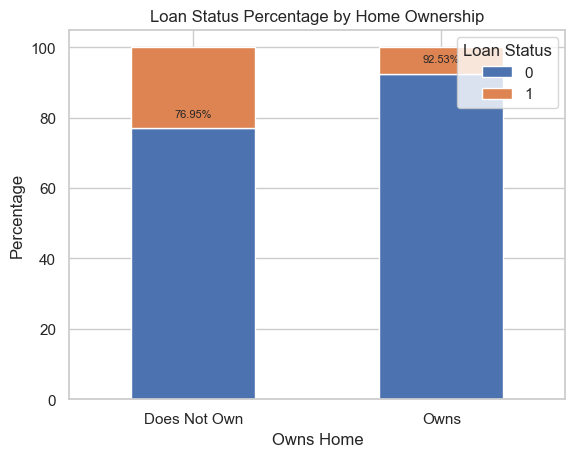

In [11]:
# Create a new binary variable 'owns_home' based on 'person_home_ownership'
dtf['owns_home'] = dtf['person_home_ownership'] == 'OWN'

# Calculate the percentage of each loan status within each home ownership category
loan_status_percentage = dtf.groupby(['owns_home', 'loan_status']).size() / dtf.groupby('owns_home').size() * 100
loan_status_percentage = loan_status_percentage.reset_index(name='percentage')

# Pivot the data for easier plotting
plot_data = loan_status_percentage.pivot(index='owns_home', columns='loan_status', values='percentage')

ax = plot_data.plot(kind='bar', stacked=True)

# Add percentage labels on top of each bar
for i in range(len(ax.patches)-2):
    ax.annotate(f'{ax.patches[i].get_height():.2f}%', (ax.patches[i].get_x() + ax.patches[i].get_width() / 2., ax.patches[i].get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.xlabel('Owns Home')
plt.ylabel('Percentage')
plt.title('Loan Status Percentage by Home Ownership')
plt.xticks([0, 1], ['Does Not Own', 'Owns'], rotation=0)
plt.legend(title='Loan Status', loc='upper right')
plt.show()

dtf = dtf.drop(['owns_home'], axis=1)


Here seems like that when a client owns a house, the more likely he'll not default a loan.

## Cleaning and Preprocessing

In [12]:
X = dtf.drop('loan_status', axis=1)
y = dtf['loan_status']

### Fill Null values:

First, let's realize which features have missing values, and then we are going to fill null values with the variable mean.

In [13]:
X.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [14]:
X["person_emp_length"] = X["person_emp_length"].fillna(X["person_emp_length"].mean())

X["loan_int_rate"] = X["loan_int_rate"].fillna(X["loan_int_rate"].mean())

X.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

We can see that we fill all the null values.

### Handle outliers

To find outliers we can examine all features using box plote

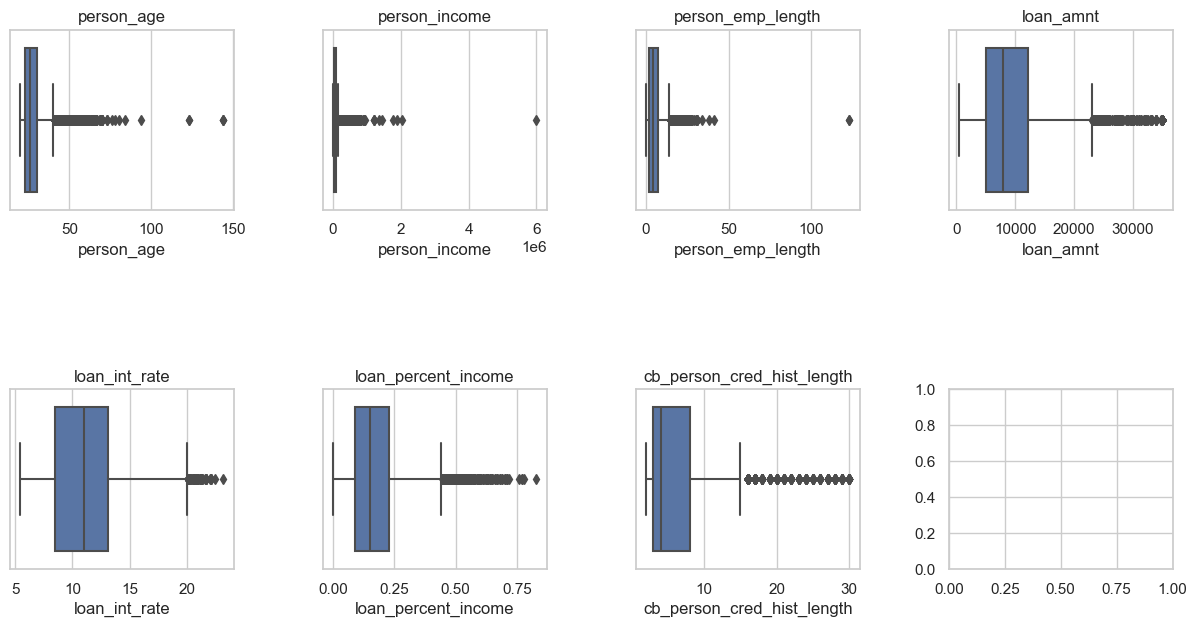

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
fig.subplots_adjust(wspace=0.4, hspace=1)

numeric_X = X.select_dtypes(include='number')
for i, feature in enumerate(numeric_X.columns):
    row, col = divmod(i, 4)
    sns.boxplot(x=X[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.show()

We can see that there is an outliers problem in all the features.
Let's handle this outliers.

We'll use this method to fix the outliers:
If the feature value is bigger the 0.95 quatile we'll set it to the 0.95 quatile value. Else, We keep it's value.

We want to mitigate the impact of outliers by setting extreme values to a less extreme but still significant values within a predefined range. The goal is to retain the information from extreme values while preventing them from disproportionately influencing the analysis or model. The approach above meets this goal.

In [16]:
X['person_age'] = np.where(X['person_age'] > 100, 100, X['person_age'])

q95 = X['person_income'].quantile(0.95)
X['person_income'] = np.where(X['person_income'] > q95, q95, X['person_income'])

q95 = X['person_emp_length'].quantile(0.95)
X['person_emp_length'] = np.where(X['person_emp_length'] > q95, q95, X['person_emp_length'])

q95 = X['loan_amnt'].quantile(0.95)
X['loan_amnt'] = np.where(X['loan_amnt'] > q95, q95, X['loan_amnt'])

q95 = X['loan_int_rate'].quantile(0.95)
X['loan_int_rate'] = np.where(X['loan_int_rate'] > q95, q95, X['loan_int_rate'])

q95 = X['loan_percent_income'].quantile(0.95)
X['loan_percent_income'] = np.where(X['loan_percent_income'] > q95, q95, X['loan_percent_income'])

q95 = X['cb_person_cred_hist_length'].quantile(0.95)
X['cb_person_cred_hist_length'] = np.where(X['cb_person_cred_hist_length'] > q95, q95, X['cb_person_cred_hist_length'])

Now, let's see if we fixed the outliers

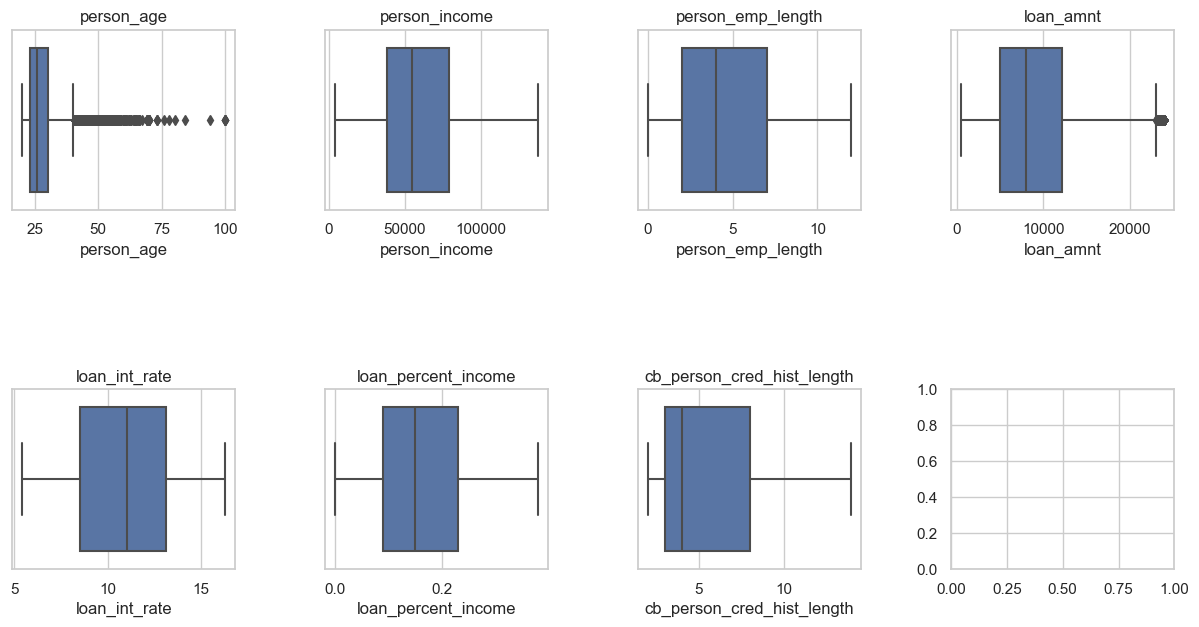

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))
fig.subplots_adjust(wspace=0.4, hspace=1)

numeric_X = X.select_dtypes(include='number')
for i, feature in enumerate(numeric_X.columns):
    row, col = divmod(i, 4)
    sns.boxplot(x=X[feature], ax=axes[row, col])
    axes[row, col].set_title(feature)

plt.show()

We can see that no outliers left except for the 'person_age' feature that we decided to keep all ages until age 90 for diversion.

### "One hot encoding" for categorical variables.

There are 4 categorical variables - 'person_home_ownership', 'loan_intent', 'loan_grade' and 'cb_person_default_on_file' <br>
First, lets examine these variables values

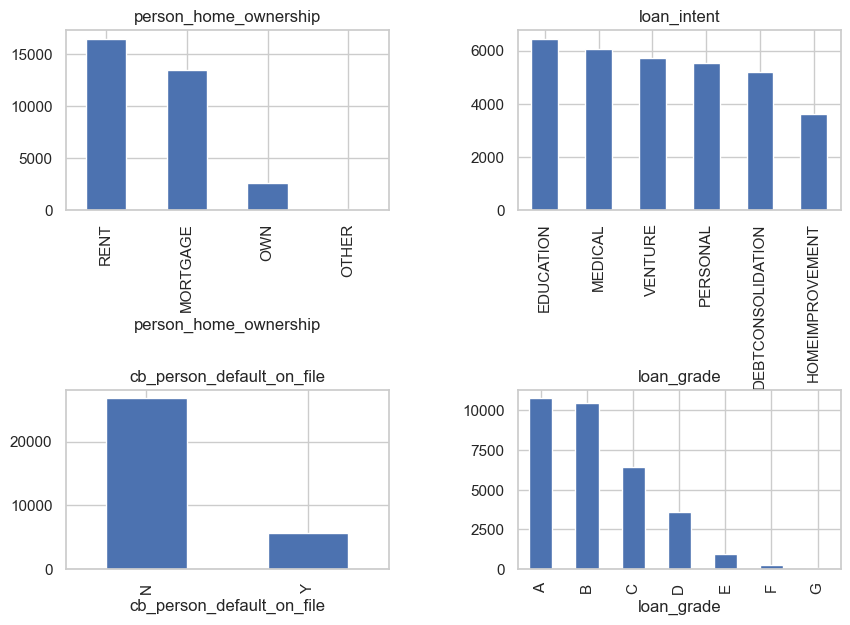

In [18]:
categorical_features = ["person_home_ownership", "loan_intent", "cb_person_default_on_file", "loan_grade"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
fig.subplots_adjust(wspace=0.4, hspace=1)

for i, feature in enumerate(categorical_features):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    vc = dtf[feature].value_counts()
    vc.plot(ax=ax, kind='bar')
    ax.set_title(feature)

plt.show()

#### Converting object data to numeric data

Now, we're going to convert this variables values to numeric.
First, insert dummy for "person_home_ownership" and "loan_intent"

In [19]:
dummy_train_person_home_ownership = pd.get_dummies(X['person_home_ownership'], prefix="person_home_ownership")

dummy_train_loan_intent = pd.get_dummies(X['loan_intent'], prefix="loan_intent")

Replacing Y to 1 and N to 0 on cb_person_default_on_file

In [20]:
X['cb_person_default_on_file_Indeed'] = X['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})

Because theres a relations between the order of the letter to the risk, we can instead map the letters to numbers

In [21]:
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
X['loan_grade_numeric'] = X['loan_grade'].map(grade_mapping)

Connecting to the original Data

In [22]:
X = pd.concat([X, dummy_train_person_home_ownership, dummy_train_loan_intent], axis=1)

X = X.drop(["person_home_ownership", "loan_intent", 'cb_person_default_on_file', 'loan_grade'], axis=1)

X.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_Indeed,loan_grade_numeric,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,22,59000.0,12.0,24000.0,16.02,0.38,3.0,1,4,False,False,False,True,False,False,False,False,True,False
1,21,9600.0,5.0,1000.0,11.14,0.10,2.0,0,2,False,False,True,False,False,True,False,False,False,False
2,25,9600.0,1.0,5500.0,12.87,0.38,3.0,0,3,True,False,False,False,False,False,False,True,False,False
3,23,65500.0,4.0,24000.0,15.23,0.38,2.0,0,3,False,False,False,True,False,False,False,True,False,False
4,24,54400.0,8.0,24000.0,14.27,0.38,4.0,1,3,False,False,False,True,False,False,False,True,False,False


## Basic ML Pipeline with XGBoost

Create a basic XGBoost Model

In [23]:
model = XGBClassifier(random_state=42)

Evaluate the model's predictive results in a 10 fold cross-validation process

In [24]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

#### Cross-Validation Results

Test statistical measures

In [25]:
print(f"Accuracy mean: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Precision mean: {np.mean(cv_results['test_precision']):.4f}")
print(f"Recall mean: {np.mean(cv_results['test_recall']):.4f}")
print(f"F1 mean: {np.mean(cv_results['test_f1']):.4f}")
print(f"Roc Auc mean: {np.mean(cv_results['test_roc_auc']):.4f}")

Accuracy mean: 0.9364
Precision mean: 0.9562
Recall mean: 0.7424
F1 mean: 0.8358
Roc Auc mean: 0.9497


## Better feature engineering


Before trying to improve the model, let's save the best cross validation results and create a function that will measure the statistical measures of a model comparing to the best results we already found. <br/>
We are going to consider this measures:


1.   **Accuracy -** Accuracy is the most intuitive performance measure, representing the proportion of correctly classified instances out of the total number of instances. It provides an overall assessment of the model's correctness. However, accuracy alone might not be sufficient if the classes are imbalanced. For example, if one class is much more prevalent than the other, a model that predicts the majority class for all instances could achieve high accuracy but fail to capture the minority class
2.   **Precision -** Precision measures the proportion of true positive predictions among all positive predictions made by the model. This is especially important in situations where it's bad if the model says something is true when it's actually false. In this dataset we don't want this situation to occur because we don't want a person to default a loan he couldn't return.
3.   **Recall -** Recall measures the proportion of true positive predictions among all actual positive instances in the dataset. In this scenario, recall is important because it measures the model's ability to capture as many instances of loan defaults as possible, even if it means some cases are incorrectly classified as non-defaults. High recall means that the model can effectively identify most of the individuals who are likely to default on their loans, helping financial institutions take proactive measures to mitigate the risks associated with defaults.
4.   **F1 -** The F1 score is the harmonic mean of precision and recall, providing a balanced measure that considers both false positives and false negatives.
5.   **ROC AUC -** provides a single scalar value that represents the model's ability to discriminate between the positive and negative classes across all possible threshold settings. This is crucial for banks because they want to minimize the number of defaults while also avoiding rejecting too many good applicants. So, a higher ROC AUC score indicates a more reliable model for making loan default predictions.





In [26]:
best_cv_results = cv_results

def PrintStatisticalMeasures(results):
  print(f"Accuracy mean: {np.mean(results['test_accuracy']):.4f}")
  print(f"Precision mean: {np.mean(results['test_precision']):.4f}")
  print(f"Recall mean: {np.mean(results['test_recall']):.4f}")
  print(f"F1 mean: {np.mean(results['test_f1']):.4f}")
  print(f"Roc Auc mean: {np.mean(results['test_roc_auc']):.4f}")

def TestStatisticalMeasures(cv_results):
  print("\033[1mBest CV results\033[0m")
  PrintStatisticalMeasures(best_cv_results)
  print("\n\033[1mNew CV results\033[0m")
  PrintStatisticalMeasures(cv_results)

### Data Imbalance

First, we saw that there is a problem of data imbalance in the dataset, there are a lot more clients which are not default on a loan, comparing to clients which are default on a loan.
Let's check if the model did predict an imbalanced results:

In [27]:
y_pred = cross_val_predict(model, X, y, cv=cv)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     25473
           1       0.96      0.74      0.84      7108

    accuracy                           0.94     32581
   macro avg       0.94      0.87      0.90     32581
weighted avg       0.94      0.94      0.93     32581



The model has shown better performance for “0” label than “1” due to an unbalanced dataset. <br/>
This class imbalance can lead to biased models that favor the majority class and perform poorly in predicting the minority class. <br/>
SMOTE is a popular technique used to address class imbalance by oversampling the minority class. Let's use it to fix this problem.

In [28]:
smote = SMOTE(random_state=42)
X_smoth, y_smoth = smote.fit_resample(X, y)
cv_results_smoth = cross_validate(model, X_smoth, y_smoth, cv=cv, scoring=scoring)

In [29]:
TestStatisticalMeasures(cv_results_smoth)

Best CV results
Accuracy mean: 0.9364
Precision mean: 0.9562
Recall mean: 0.7424
F1 mean: 0.8358
Roc Auc mean: 0.9497

New CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866


We can see that it indeed improved the model in all measures then we'll use this data.

In [30]:
best_cv_results = cv_results_smoth
X = X_smoth
y = y_smoth

### Feature Scaling

Ensuring that numerical features with varying scales contribute equally to the model is essential, and that's where feature scaling comes in. It prevents any single feature from overshadowing others, promoting balanced model performance. Let's see if it'll improve the model measures.

In [31]:
X_standard = StandardScaler().fit_transform(X)

In [32]:
cv_results_standard = cross_validate(model, X_standard, y, cv=cv, scoring=scoring)

In [33]:
TestStatisticalMeasures(cv_results_standard)

Best CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9582
Precision mean: 0.9898
Recall mean: 0.9260
F1 mean: 0.9568
Roc Auc mean: 0.9868


We can see that it improved the model only on Roc Auc measure, but it is not significant and it did not improved the model in all other measures then we'll not use the data after scaling.

### Feature Selection

When doing feature selection it involves identifying the most important features for a particular modeling objective. By reducing the number of features, it can improve the model performance, mitigate overfitting, and speed the training. It goal is to simplify the model's task by excluding unnecessary elements. <br/>
For that we'll use RFE. The main goal of RFE is to identify a subset of features that maximizes the performance of the model while minimizing redundancy and overfitting. We'll see the results when selecting 5 or 10 features.

In [34]:
rfe_5 = RFE(model, n_features_to_select=5)
rfe_5.fit(X, y)

X_selected = rfe_5.transform(X)
cv_results_selected = cross_validate(model, X_selected, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_selected)

Best CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.8562
Precision mean: 0.9268
Recall mean: 0.7735
F1 mean: 0.8432
Roc Auc mean: 0.9250


In [35]:
rfe_10 = RFE(model, n_features_to_select=10)
rfe_10.fit(X, y)

X_selected = rfe_10.transform(X)
cv_results_selected = cross_validate(model, X_selected, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_selected)

Best CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9204
Precision mean: 0.9699
Recall mean: 0.8679
F1 mean: 0.9160
Roc Auc mean: 0.9614


We can see that it did not improved the model then we'll not use this method. <br/>
We'll try using different approach. Let's analyze which features are dependant on each other using correlation matrix

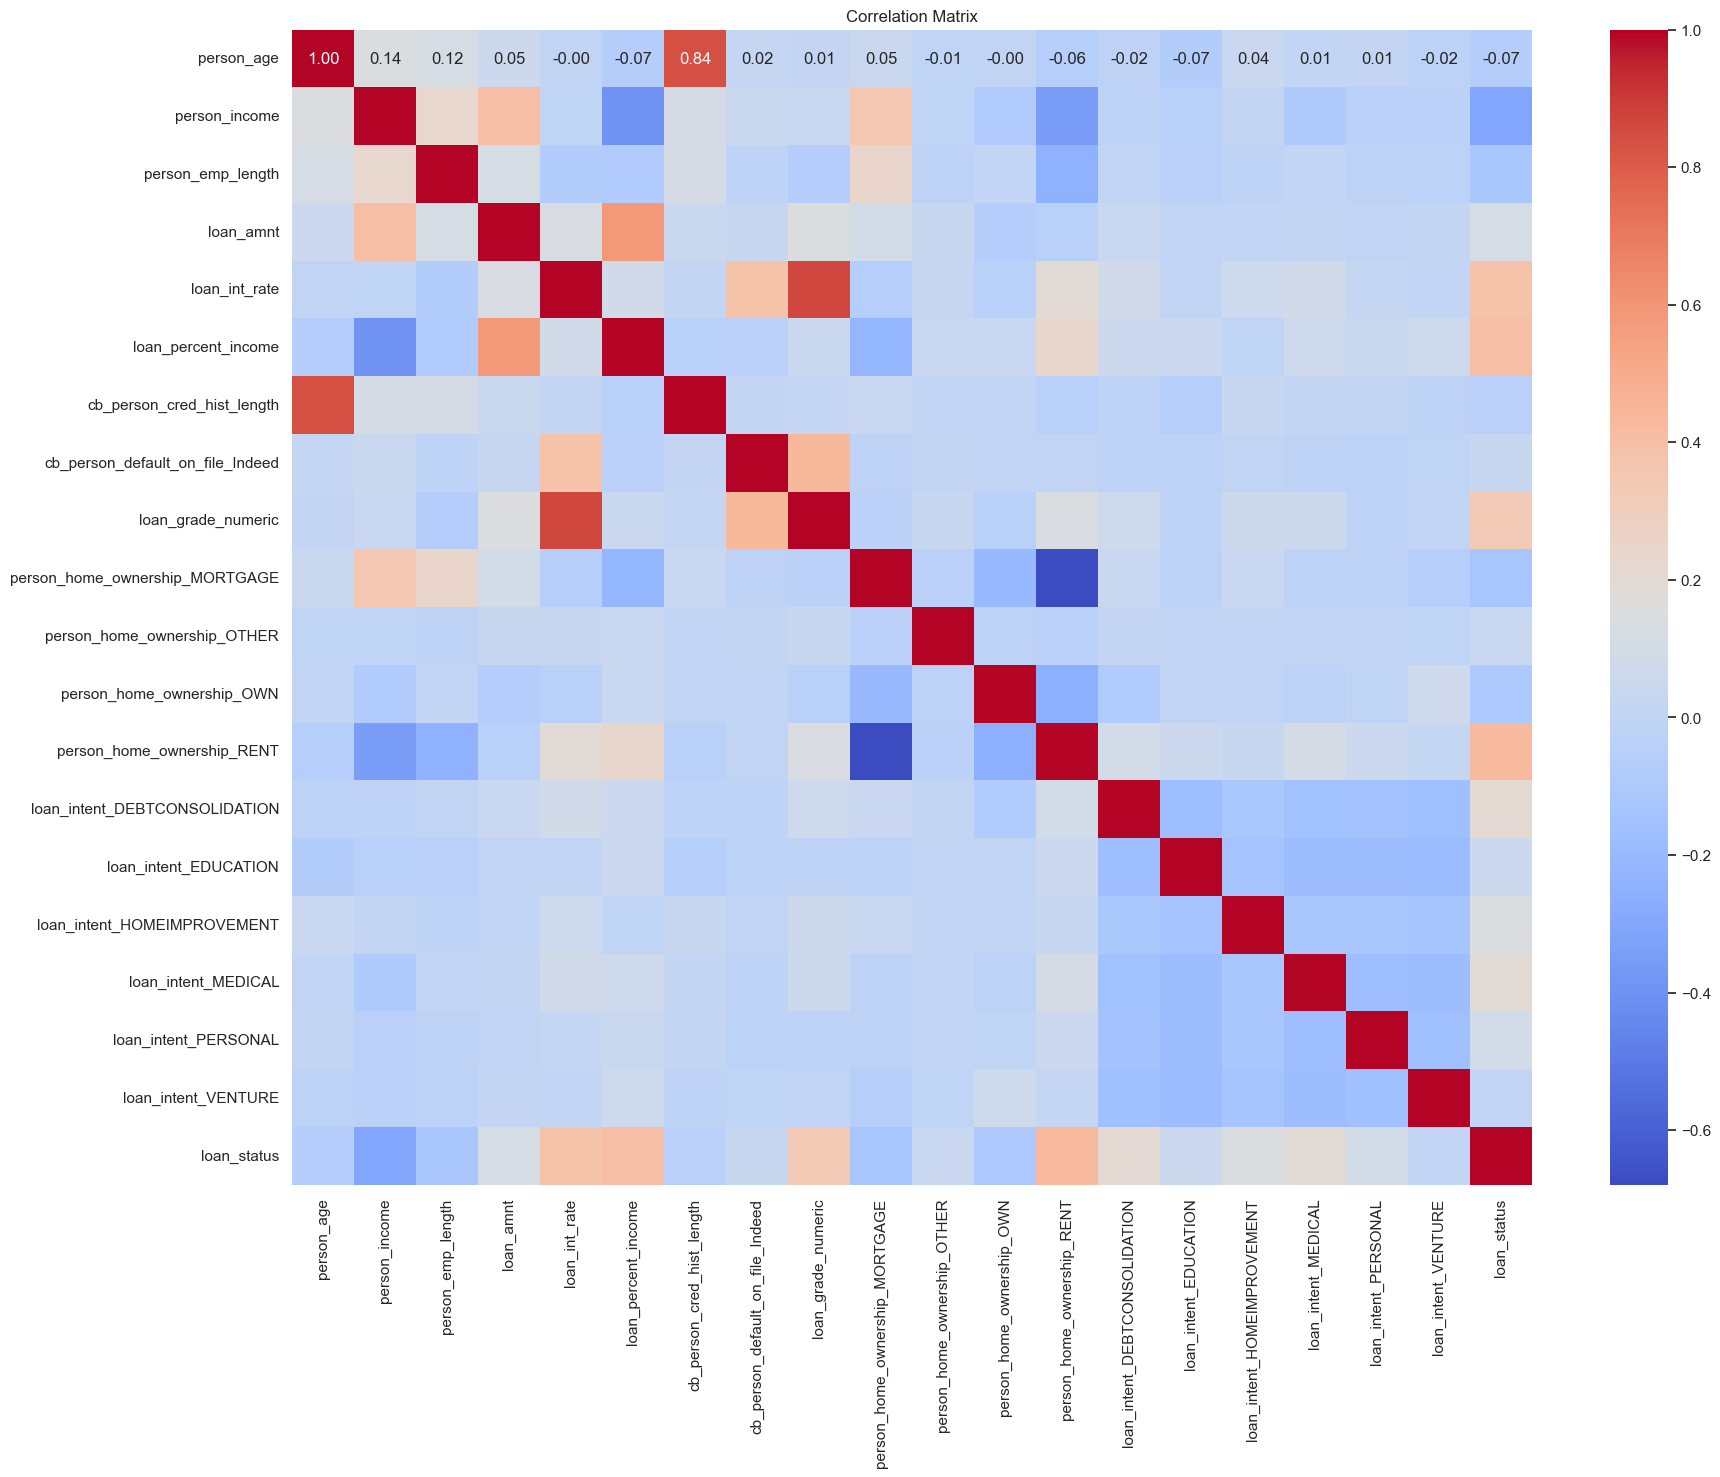

In [36]:
correlation_matrix = pd.concat([X, y], axis=1).corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We can conclude from the correlation matrix that:
1. 'cb_person_cred_hist_length' and 'person_age' are highly linear correlated (0.84) which make sense beacuse older people have more history.
2. 'loan_grade_numeric' and 'loan_int_rate' are highly linear correlated (0.86) which make sense beacuse they both relate to the loan amount.

Let's evaluate the features importance:

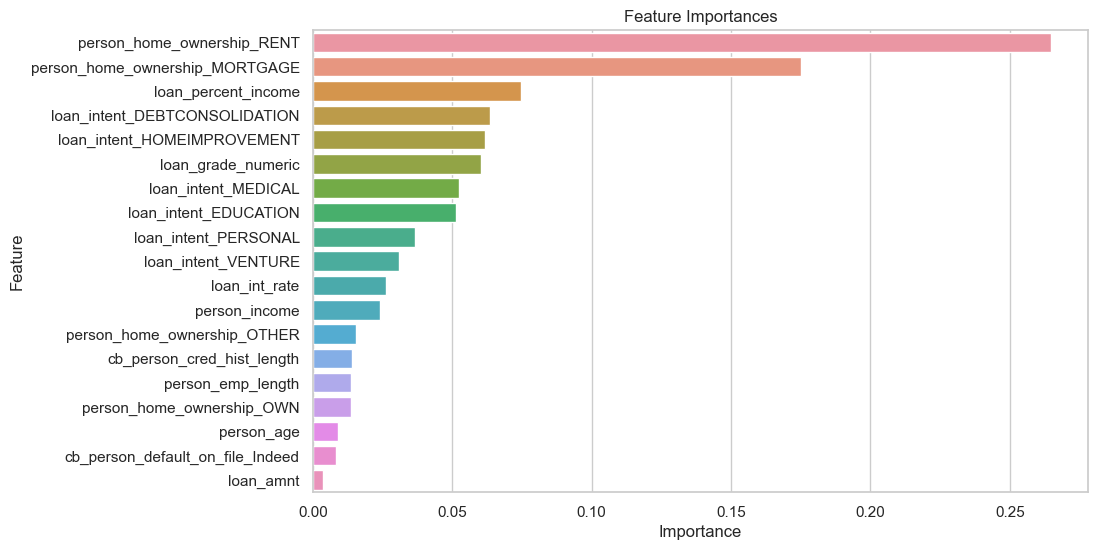

In [37]:
model.fit(X,y)
feature_importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

We can see that 'person_age' have less importance than 'cb_person_cred_hist_length', we'll try removing it

In [38]:
X_drop = X.drop(['person_age'], axis=1)

cv_results_drop = cross_validate(model, X_drop, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_drop)

Best CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9564
Precision mean: 0.9881
Recall mean: 0.9240
F1 mean: 0.9550
Roc Auc mean: 0.9861


It does not improve the model. <br/>
In addition, we can see that 'loan_int_rate' have less importance than 'loan_grade_numeric', we'll try removing it

In [39]:
X_drop = X.drop(['loan_int_rate'], axis=1)

cv_results_drop = cross_validate(model, X_drop, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_drop)

Best CV results
Accuracy mean: 0.9584
Precision mean: 0.9900
Recall mean: 0.9262
F1 mean: 0.9570
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866


We can see it improved the model in measures of accuracy, precision and F1 then we'll continue with this data

In [40]:
best_cv_results = cv_results_drop
X = X_drop

### Feature Binning


Now, we are going to try divide continuous features into categories and check which dividing will enahance the model measures. <br/>
We'll try do this on these features:


1.   person_age
2.   person_income
3.   person_emp_length
4.   loan_amnt



#### person_age

In [41]:
print(X['person_age'].min(), X['person_age'].max())

20 100


We're introducing a new feature called 'age_category', with the following value assignments:

1. '20-30' if 'person_age' is greater than or equal to 20 and less than 30.
2. '30-40' if 'person_age' is greater than or equal to 30 and less than 40.
3. '40-50' if 'person_age' is greater than or equal to 40 and less than 50.
4. '50-60' if 'person_age' is greater than or equal to 50 and less than 60.
5. '60+' if 'person_age' is greater than or equal to 60.

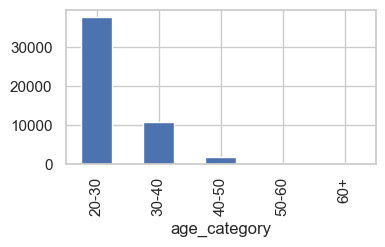

In [42]:
age_bins = [20, 30, 40, 50, 60, float('inf')]
age_labels = ['20-30', '30-40', '40-50', '50-60', '60+']

X_age_categories = X.copy()
X_age_categories['age_category'] = pd.cut(X_age_categories['person_age'], bins=age_bins, labels=age_labels, right=False)
X_age_categories['age_category'].value_counts()

fig, ax = plt.subplots(figsize=(4, 2))
vc = X_age_categories['age_category'].value_counts()
vc.plot(ax=ax, kind='bar')
plt.show()

We'll now one-hot encode this new categorical feature, similar to how we've handled previous categorical features. Additionally, we'll remove both the new feature 'age_category' and the original feature it was derived from, 'person_age'.

In [43]:
dummy_train_person_age = pd.get_dummies(X_age_categories['age_category'], prefix='age')
X_age_categories = pd.concat([X_age_categories, dummy_train_person_age], axis=1)
X_age_categories = X_age_categories.drop(['age_category', 'person_age'], axis=1)

X_age_categories.head()

,person_income,person_emp_length,loan_amnt,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_Indeed,loan_grade_numeric,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,age_20-30,age_30-40,age_40-50,age_50-60,age_60+
0,59000.0,12.0,24000.0,0.38,3.0,1,4,False,False,False,...,False,False,False,True,False,True,False,False,False,False
1,9600.0,5.0,1000.0,0.10,2.0,0,2,False,False,True,...,True,False,False,False,False,True,False,False,False,False
2,9600.0,1.0,5500.0,0.38,3.0,0,3,True,False,False,...,False,False,True,False,False,True,False,False,False,False
3,65500.0,4.0,24000.0,0.38,2.0,0,3,False,False,False,...,False,False,True,False,False,True,False,False,False,False
4,54400.0,8.0,24000.0,0.38,4.0,1,3,False,False,False,...,False,False,True,False,False,True,False,False,False,False


After bining the 'person_age' feature, we'll run the model and check if it enhanced the model measures.

In [44]:
cv_results_age_categories = cross_validate(model, X_age_categories, y, cv=cv, scoring=scoring)

In [45]:
TestStatisticalMeasures(cv_results_age_categories)

Best CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9572
Precision mean: 0.9895
Recall mean: 0.9242
F1 mean: 0.9558
Roc Auc mean: 0.9859


We can see that it did not improved the model then we'll not use this data.

#### person_income

In [46]:
print(X['person_income'].min(), X['person_income'].max())

4000.0 138000.0


We're introducing a new feature called 'income_category', with the following value assignments:

1. '4-20' if 'person_income' is greater than or equal to 4 and less than 20.
2. '20-40' if 'person_income' is greater than or equal to 20 and less than 40.
3. '40-60' if 'person_income' is greater than or equal to 40 and less than 60.
4. '60-80' if 'person_income' is greater than or equal to 60 and less than 80.
5. '80-100' if 'person_income' is greater than or equal to 80 and less than 100.
6. '100-120' if 'person_income' is greater than or equal to 100 and less than 120.
7. '120+' if 'person_income' is greater than or equal to 120.

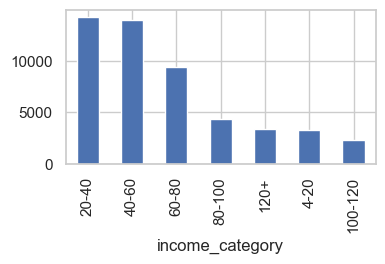

In [47]:
income_bins = [4000, 20000, 40000, 60000, 80000, 100000, 120000, float('inf')]
income_labels = ['4-20', '20-40', '40-60', '60-80', '80-100', '100-120', '120+']

X_income_categories = X.copy()
X_income_categories['income_category'] = pd.cut(X_income_categories['person_income'], bins=income_bins, labels=income_labels, right=False)
X_income_categories['income_category'].value_counts()

fig, ax = plt.subplots(figsize=(4, 2))
vc = X_income_categories['income_category'].value_counts()
vc.plot(ax=ax, kind='bar')
plt.show()

We'll now one-hot encode this new categorical feature, similar to how we've handled previous categorical features. Additionally, we'll remove both the new feature 'income_category' and the original feature it was derived from, 'person_income'.

In [48]:
dummy_train_person_income = pd.get_dummies(X_income_categories['income_category'], prefix='income')
X_income_categories = pd.concat([X_income_categories, dummy_train_person_income], axis=1)
X_income_categories = X_income_categories.drop(['income_category', 'person_income'], axis=1)

X_income_categories.head()

,person_age,person_emp_length,loan_amnt,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_Indeed,loan_grade_numeric,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,income_4-20,income_20-40,income_40-60,income_60-80,income_80-100,income_100-120,income_120+
0,22,12.0,24000.0,0.38,3.0,1,4,False,False,False,...,False,True,False,False,False,True,False,False,False,False
1,21,5.0,1000.0,0.10,2.0,0,2,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,25,1.0,5500.0,0.38,3.0,0,3,True,False,False,...,True,False,False,True,False,False,False,False,False,False
3,23,4.0,24000.0,0.38,2.0,0,3,False,False,False,...,True,False,False,False,False,False,True,False,False,False
4,24,8.0,24000.0,0.38,4.0,1,3,False,False,False,...,True,False,False,False,False,True,False,False,False,False


After bining the 'person_income' feature, we'll run the model and check if it enhanced the model measures.

In [49]:
cv_results_income_categories = cross_validate(model, X_income_categories, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_income_categories)

Best CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9571
Precision mean: 0.9932
Recall mean: 0.9204
F1 mean: 0.9554
Roc Auc mean: 0.9813


We can see that it only improved the model in the percision measure, but in all other measures it did not then we'll not use this data.

#### person_emp_length

In [50]:
print(X['person_emp_length'].min(), X['person_emp_length'].max())

0.0 12.0


We're introducing a new feature called 'emp_length_category', with the following value assignments:

1. '0-3' if 'person_emp_length' is greater than or equal to 0 and less than 3.
2. '3-6' if 'person_emp_length' is greater than or equal to 3 and less than 6.
3. '6-9' if 'person_emp_length' is greater than or equal to 6 and less than 9.
4. '9+' if 'person_emp_length' is greater than or equal to 9.

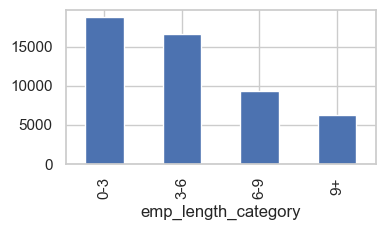

In [51]:
emp_length_bins = [0, 3, 6, 9, float('inf')]
emp_length_labels = ['0-3', '3-6', '6-9', '9+']

X_emp_length_categories = X.copy()
X_emp_length_categories['emp_length_category'] = pd.cut(X_emp_length_categories['person_emp_length'], bins=emp_length_bins, labels=emp_length_labels, right=False)
X_emp_length_categories['emp_length_category'].value_counts()

fig, ax = plt.subplots(figsize=(4, 2))
vc = X_emp_length_categories['emp_length_category'].value_counts()
vc.plot(ax=ax, kind='bar')
plt.show()

We'll now one-hot encode this new categorical feature, similar to how we've handled previous categorical features. Additionally, we'll remove both the new feature 'emp_length_category' and the original feature it was derived from, 'person_emp_length'.

In [52]:
dummy_train_person_emp_length = pd.get_dummies(X_emp_length_categories['emp_length_category'], prefix='emp_length')
X_emp_length_categories = pd.concat([X_emp_length_categories, dummy_train_person_emp_length], axis=1)
X_emp_length_categories = X_emp_length_categories.drop(['emp_length_category', 'person_emp_length'], axis=1)

X_emp_length_categories.head()

,person_age,person_income,loan_amnt,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_Indeed,loan_grade_numeric,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,emp_length_0-3,emp_length_3-6,emp_length_6-9,emp_length_9+
0,22,59000.0,24000.0,0.38,3.0,1,4,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,21,9600.0,1000.0,0.10,2.0,0,2,False,False,True,...,False,True,False,False,False,False,False,True,False,False
2,25,9600.0,5500.0,0.38,3.0,0,3,True,False,False,...,False,False,False,True,False,False,True,False,False,False
3,23,65500.0,24000.0,0.38,2.0,0,3,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,24,54400.0,24000.0,0.38,4.0,1,3,False,False,False,...,False,False,False,True,False,False,False,False,True,False


After bining the 'person_emp_length' feature, we'll run the model and check if it enhanced the model measures.

In [53]:
cv_results_emp_length_categories = cross_validate(model, X_emp_length_categories, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_emp_length_categories)

Best CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9568
Precision mean: 0.9902
Recall mean: 0.9228
F1 mean: 0.9553
Roc Auc mean: 0.9865


We can see that it did not improved the model then we'll not use this data.

#### loan_amnt

In [54]:
print(X['loan_amnt'].min(), X['loan_amnt'].max())

500.0 24000.0


We're introducing a new feature called 'loan_amnt_category', with the following value assignments:

1. '0-5' if 'loan_amnt' is greater than or equal to 0 and less than 5.
2. '5-10' if 'loan_amnt' is greater than or equal to 5 and less than 10.
3. '10-15' if 'loan_amnt' is greater than or equal to 10 and less than 15.
4. '15-20' if 'loan_amnt' is greater than or equal to 15 and less than 20.
5. '20+' if 'loan_amnt' is greater than or equal to 20.

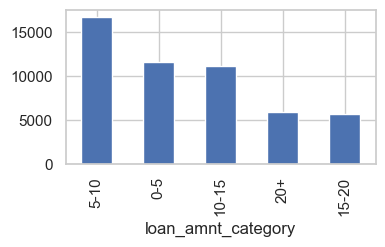

In [55]:
loan_amnt_bins = [0, 5000, 10000, 15000, 20000, float('inf')]
loan_amnt_labels = ['0-5', '5-10', '10-15', '15-20', '20+']

X_loan_amnt_categories = X.copy()
X_loan_amnt_categories['loan_amnt_category'] = pd.cut(X_loan_amnt_categories['loan_amnt'], bins=loan_amnt_bins, labels=loan_amnt_labels, right=False)
X_loan_amnt_categories['loan_amnt_category'].value_counts()

fig, ax = plt.subplots(figsize=(4, 2))
vc = X_loan_amnt_categories['loan_amnt_category'].value_counts()
vc.plot(ax=ax, kind='bar')
plt.show()

We'll now one-hot encode this new categorical feature, similar to how we've handled previous categorical features. Additionally, we'll remove both the new feature 'loan_amnt_category' and the original feature it was derived from, 'loan_amnt'.

In [56]:
dummy_train_person_loan_amnt = pd.get_dummies(X_loan_amnt_categories['loan_amnt_category'], prefix='loan_amnt')
X_loan_amnt_categories = pd.concat([X_loan_amnt_categories, dummy_train_person_loan_amnt], axis=1)
X_loan_amnt_categories = X_loan_amnt_categories.drop(['loan_amnt_category', 'loan_amnt'], axis=1)

X_loan_amnt_categories.head()

,person_age,person_income,person_emp_length,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_Indeed,loan_grade_numeric,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_amnt_0-5,loan_amnt_5-10,loan_amnt_10-15,loan_amnt_15-20,loan_amnt_20+
0,22,59000.0,12.0,0.38,3.0,1,4,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,21,9600.0,5.0,0.10,2.0,0,2,False,False,True,...,True,False,False,False,False,True,False,False,False,False
2,25,9600.0,1.0,0.38,3.0,0,3,True,False,False,...,False,False,True,False,False,False,True,False,False,False
3,23,65500.0,4.0,0.38,2.0,0,3,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,24,54400.0,8.0,0.38,4.0,1,3,False,False,False,...,False,False,True,False,False,False,False,False,False,True


After bining the 'loan_amnt' feature, we'll run the model and check if it enhanced the model measures.

In [57]:
cv_results_loan_amnt_categories = cross_validate(model, X_loan_amnt_categories, y, cv=cv, scoring=scoring)
TestStatisticalMeasures(cv_results_loan_amnt_categories)

Best CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9578
Precision mean: 0.9894
Recall mean: 0.9255
F1 mean: 0.9564
Roc Auc mean: 0.9862


We can see that it did not improved the model then we'll not use this data.

## Better ML model

We'll now explore XGBoost, LightGBM, and Random Forest models, conduct parameter tuning, and determine the most optimal model among them.
<br/>
<br/>
XGBoost, LightGBM, and Random Forest are often considered among the best models for binary classification tasks with tabular datasets due to several reasons and because of that reasons we'll explore these models:

1. **Performance -** These algorithms are known for their high performance and effectiveness in handling tabular data.

2. **Ensemble Learning -** These algorithms are all ensemble learning methods, which means they combine multiple base models (trees in this case) to make predictions. Ensemble methods tend to reduce overfitting and improve generalization compared to individual models.

3. **Tree-based Models -** These algorithms are based on decision trees, which naturally handle tabular data well. They can capture complex interactions and non-linear relationships between features, making them suitable for a wide range of datasets.

4. **Scalability -** XGBoost and LightGBM are designed for efficiency and scalability, making them capable of handling large datasets with many features.

In the parameters tuning for all models, we'll consider the ROC AUC measure as the primary scoring metric.
ROC AUC is chosen as the primary evaluation metric because it takes into consideration both the positive and negative classes across all possible threshold settings and its robustness to imbalanced datasets, crucial for predicting loan defaults.

### XGBoost model

#### Parameters Tuning

We already saw this model statistical measures values, now we measure the model with various parameters to identify which ones enhance its performance. <br/>

*The parameters we chose to tune:*
1. **Learning Rate -** This parameter controls the step size at each iteration while moving toward a minimum of the loss function. A lower learning rate may require more iterations to converge but may result in better performance. We're sampling uniformly from the range [0.001, 0.3] to explore a wide range of values.

2. **Number of Estimators -** This is the number of boosting rounds or decision trees to be built. More estimators can potentially lead to better performance but may also increase the risk of overfitting. We're sampling uniformly from the range [100, 1000] to consider a wide range of tree numbers.

3. **Maximum Depth of Trees -** This parameter limits the maximum depth of each tree. Deeper trees can model more complex relationships in the data but may also lead to overfitting. We're sampling uniformly from the range [3, 10] to explore different tree depths.

4. **Minimum Child Weight -** This parameter defines the minimum sum of weights of all observations required in a child. It helps control overfitting by adding regularization. We're sampling uniformly from the range [1, 10] to explore different values.

5. **Gamma -** This parameter specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. It acts as regularization by penalizing large trees. We're sampling uniformly from the range [0, 0.5] to explore different levels of regularization.

6. **Subsample -** This parameter specifies the fraction of observations to be randomly sampled for each tree. It helps in preventing overfitting. We're sampling uniformly from the range [0.6, 1.0] to explore different fractions of subsampling.

7. **Colsample by Tree -** This parameter specifies the fraction of features to be randomly sampled for each tree. It helps in preventing overfitting by introducing randomness. We're sampling uniformly from the range [0.6, 1.0] to explore different fractions of feature subsampling.

In [58]:
param_dist = {
    'learning_rate': uniform(0.001, 0.3),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 1),
    'colsample_bytree': uniform(0.6, 1),
}

xgb_model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, scoring='roc_auc', cv=cv, n_iter=20, random_state=42, n_jobs=-1)
random_result = random_search.fit(X, y)

xgb_best_params = random_result.best_params_
xgb_best_score = random_result.best_score_
print("Best Parameters:", xgb_best_params)
print("Best Score:", xgb_best_score)

Best Parameters: {'colsample_bytree': 0.9243450210052739, 'gamma': 0.061043977350336676, 'learning_rate': 0.10788935142309247, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 484, 'subsample': 0.8279351625419417}
Best Score: 0.9868266521982045


### LightGBM model

First, let's check what is the model statistical measures values

In [59]:
lgbm_model = LGBMClassifier(verbose=-1, random_state=42)
cv_results_lgbm = cross_validate(lgbm_model, X, y, cv=cv, scoring=scoring)
PrintStatisticalMeasures(cv_results_lgbm)

Accuracy mean: 0.9555
Precision mean: 0.9955
Recall mean: 0.9151
F1 mean: 0.9536
Roc Auc mean: 0.9850


#### Parameters Tuning

Now we measure the model with various parameters to identify which ones enhance its performance. <br/>

*The parameters we chose to tune:*
1. **Learning Rate -** Similar to XGBoost.

2. **Number of Iterations -** Similar to XGBoost for number of estimators.

3. **Maximum Depth of Trees -** Similar to XGBoost.

4. **Minimum Child Samples -** This parameter specifies the minimum number of samples required to be at a leaf node. It helps control overfitting by setting a threshold for node creation. We're sampling uniformly from the range [1, 20] to explore different values.

6. **Subsample -** Similar to XGBoost.

7. **Colsample by Tree -** Similar to XGBoost.

8. **Regularization Alpha -** This parameter adds L1 regularization term on weights to make models more robust to outliers. We're sampling uniformly from the range [0, 0.1] to explore different levels of L1 regularization.

9. **Regularization Lambda -** This parameter adds L2 regularization term on weights to make models more robust to outliers. We're sampling uniformly from the range [0, 0.1] to explore different levels of L2 regularization.

In [60]:
import lgbm_parameters_tuning
lgbm_best_params = lgbm_parameters_tuning.run_parameters_tuning(lgbm_model, cv, X, y)

This cell run may take a while, Do you want to skip the cell run and load variables from a file? (yes/no): 

 no


Best Parameters: {'bagging_fraction': 0.3951502360018144, 'colsample_bytree': 1.5266588657937943, 'feature_fraction': 0.7272719958564209, 'learning_rate': 0.09896223064175061, 'max_depth': 8, 'min_child_samples': 8, 'n_estimators': 824, 'reg_alpha': 0.038867728968948204, 'reg_lambda': 0.02713490317738959, 'subsample': 1.4287375091519294}
Best Score: 0.9870514744743801


### Random Forest model

We also checked Random Forst model. To reduce running time, we won't keep here the tuning for this model because the result wasn't better then the XGBoost or LightGBM.

### Comparing the different models

In [61]:
best_model_xgb = XGBClassifier(**xgb_best_params, random_state=42)
cv_results_xgb = cross_validate(best_model_xgb, X, y, cv=cv, scoring=scoring)
print("\033[1mBest Score XGBoost model:\033[0m")
PrintStatisticalMeasures(cv_results_xgb)
print("\n")

best_model_lgbm = LGBMClassifier(**lgbm_best_params, random_state=42, verbose=-1)
cv_results_lgbm = cross_validate(best_model_lgbm, X, y, cv=cv, scoring=scoring)
print("\033[1mBest Score LightGBM model:\033[0m")
PrintStatisticalMeasures(cv_results_lgbm)
print("\n")

Best Score XGBoost model:
Accuracy mean: 0.9601
Precision mean: 0.9860
Recall mean: 0.9334
F1 mean: 0.9590
Roc Auc mean: 0.9868


Best Score LightGBM model:
Accuracy mean: 0.9611
Precision mean: 0.9895
Recall mean: 0.9321
F1 mean: 0.9599
Roc Auc mean: 0.9871




We can see that LightGBM  is the model with the best measures then we'll use it as the final model

In [62]:
model = best_model_lgbm
TestStatisticalMeasures(cv_results_lgbm)

Best CV results
Accuracy mean: 0.9583
Precision mean: 0.9902
Recall mean: 0.9259
F1 mean: 0.9569
Roc Auc mean: 0.9866

New CV results
Accuracy mean: 0.9611
Precision mean: 0.9895
Recall mean: 0.9321
F1 mean: 0.9599
Roc Auc mean: 0.9871


## Model Analayzing


In this section, we will analyze the LightGBM model using SHAP, a tool that provides insights into how the model makes predictions and how each feature contributes to the model's decisions.

Using SHAP, we can:
1. **Visualize feature importance -** Identify which features have the most impact on the model's predictions.
2. **Interpret model predictions -** Understand how features affect individual predictions.
3. **Evaluate model fairness -** Assess how the model treats different groups or features.

It is important in our DB because if a client non defalts a loan, he wants to know why, and with this tool we can analyze why.

We now proceed with the SHAP analysis of the model to gain a deeper understanding of its performance and internal workings.

In [63]:
model.fit(X,y)

LGBMClassifier(bagging_fraction=0.3951502360018144,
               colsample_bytree=1.5266588657937943,
               feature_fraction=0.7272719958564209,
               learning_rate=0.09896223064175061, max_depth=8,
               min_child_samples=8, n_estimators=824, random_state=42,
               reg_alpha=0.038867728968948204, reg_lambda=0.02713490317738959,
               subsample=1.4287375091519294, verbose=-1)

Calculating the SHAP values for the entire dataset

In [64]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Bar Plot

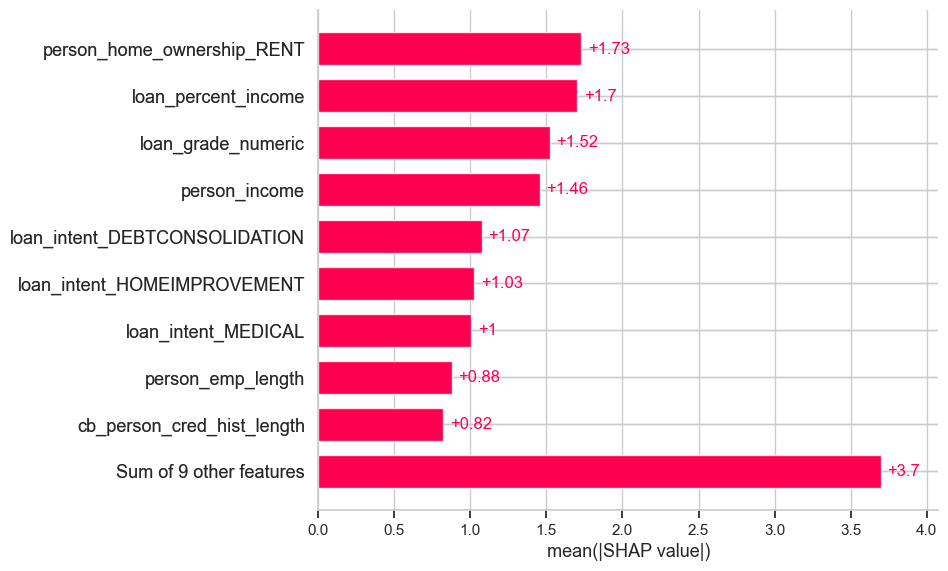

In [65]:
shap.plots.bar(explainer(X))

From the bar we can understand that:
* person_home_ownership_RENT, "loan_percent_income", "loan_grade_numeric" and "person_income" are highly important to determine the results.

We can also look at a local feature importance plot.

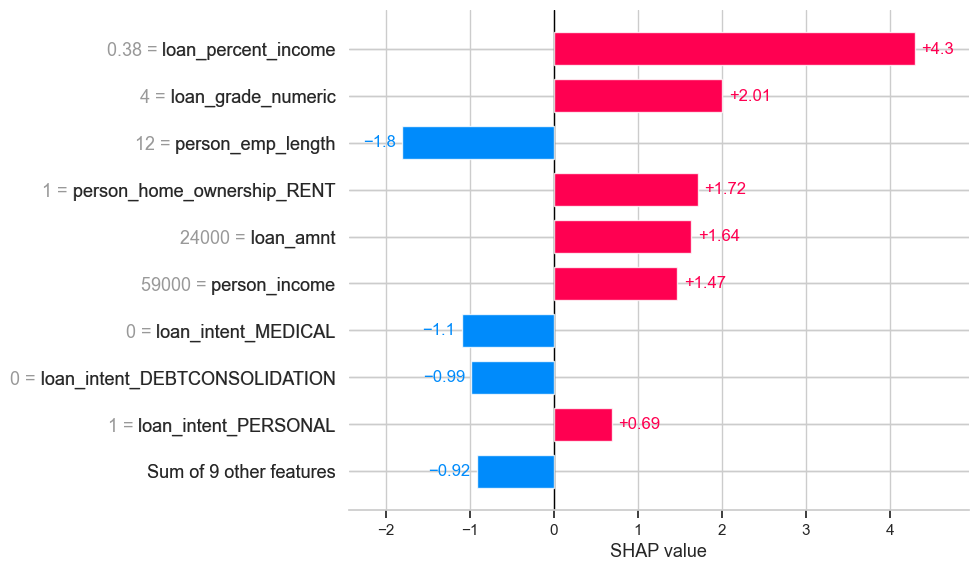

In [66]:
shap.plots.bar(explainer(X)[0])

From the local bar we can understand that:
* The most important features "loan_percent_income", "loan_grade_numeric", "person_home_ownership_RENT" and "loan_amnt" have a positive impact on the prediction.
* Low values of "person_emp_length", 'loan_intent_MEDICAL" and "loan_intent_DEBTCONSOLIDATION" have a negative impact on the prediction.

### Summary Plot
The summary plot shows the feature importance of each feature in the model. The results show that “Status,” “Complaints,” and “Frequency of use” play major roles in determining the results.



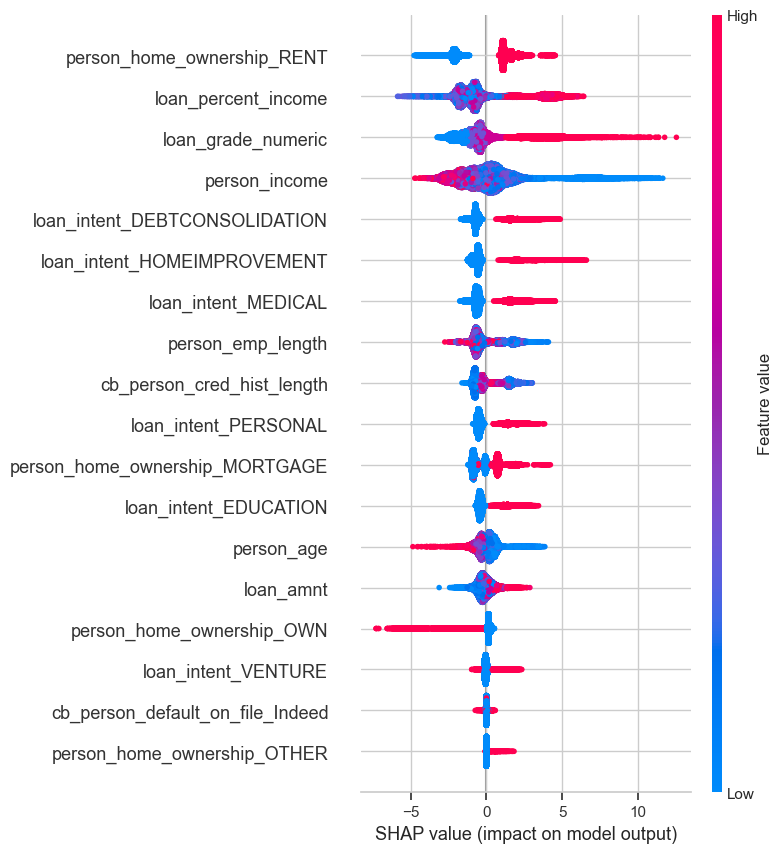

In [67]:
shap.summary_plot(shap_values, X)

From the summary plot we can understand that:
* Higher "person_home_ownership_RENT", "loan_percent_income", and "loan_grade_numeric" values have a positive impact on the prediction, while lower values have a negative impact.
* Higher "person_income" and "person_age" values have a negative impact on the prediction, while lower values have a positive impact.

### Dependence Plot

A dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model. We'll choose a top feature and create a dependence plot to understand how the feature affects predictions across different values

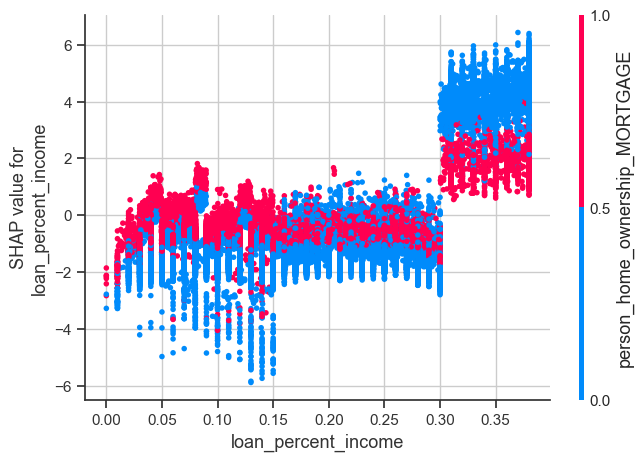

In [71]:
shap.dependence_plot("loan_percent_income", shap_values, X)

We can understand that:
* Lower "loan_percent_income" values with no mortgage taken ("person_home_ownership_MORTGAGE" = 0), are less likely to default a loan then lower "loan_percent_income" values with mortgage taken ("person_home_ownership_MORTGAGE" = 1).
* Higher "loan_percent_income" values with mortgage taken ("person_home_ownership_MORTGAGE" = 1), are less likely to default a loan then higher "loan_percent_income" values with mortgage taken ("person_home_ownership_MORTGAGE" = 1),

### Force Plot

## Reference to external resources


*   https://shap.readthedocs.io/en/latest/
*   https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability
*   https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

